In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2017'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2017'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2017/apr17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/aug17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/dec17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/feb17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/jan17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/jul17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/jun17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/mar17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/may17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/nov17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/oc17.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2017/sep17.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 24.3 s, sys: 68.4 ms, total: 24.3 s
Wall time: 39.6 s


In [ ]:
## cleanup columns
#df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119727 entries, 0 to 119726
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          119727 non-null  object 
 1   Hour          119727 non-null  int64  
 2   Offense Type  119727 non-null  object 
 3   Beat          119727 non-null  object 
 4   Premise       119240 non-null  object 
 5   BlockRange    40378 non-null   object 
 6   StreetName    40378 non-null   object 
 7   Type          119727 non-null  object 
 8   Suffix        119727 non-null  object 
 9   . offenses    40378 non-null   float64
 10  Block Range   79349 non-null   object 
 11  Street Name   79347 non-null   object 
 12  Offenses      79349 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 11.9+ MB


In [9]:
df.head()

,Date,Hour,Offense Type,Beat,Premise,BlockRange,StreetName,Type,Suffix,. offenses,Block Range,Street Name,Offenses
0,2017-04-10 00:00:00,15,Burglary,10H10,Residence or House,200-299,CLIFTON,-,-,1.0,NaN,NaN,NaN
1,2017-04-11 00:00:00,15,Theft,10H10,Restaurant or Cafeteria Parking Lot,2300-2399,CANAL,ST,-,1.0,NaN,NaN,NaN
2,2017-04-11 00:00:00,17,Theft,10H10,Restaurant or Cafeteria Parking Lot,2300-2399,CANAL,ST,-,1.0,NaN,NaN,NaN
3,2017-04-12 00:00:00,9,Burglary,10H10,Miscellaneous Business (Non-Specific),4600-4699,CANAL,ST,-,1.0,NaN,NaN,NaN
4,2017-04-12 00:00:00,19,Theft,10H10,"Other, Unknown, or Not Listed",100-199,ADAM,LN,-,1.0,NaN,NaN,NaN


## Show null data

In [10]:
df.apply(lambda x: sum(x.isnull()))

Date                0
Hour                0
Offense Type        0
Beat                0
Premise           487
BlockRange      79349
StreetName      79349
Type                0
Suffix              0
. offenses      79349
Block Range     40378
Street Name     40380
Offenses        40378
dtype: int64

In [11]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
BlockRange,66.27
StreetName,66.27
. offenses,66.27
Block Range,33.73
Street Name,33.73
Offenses,33.73
Premise,0.41
Date,0.00
Hour,0.00
Offense Type,0.00


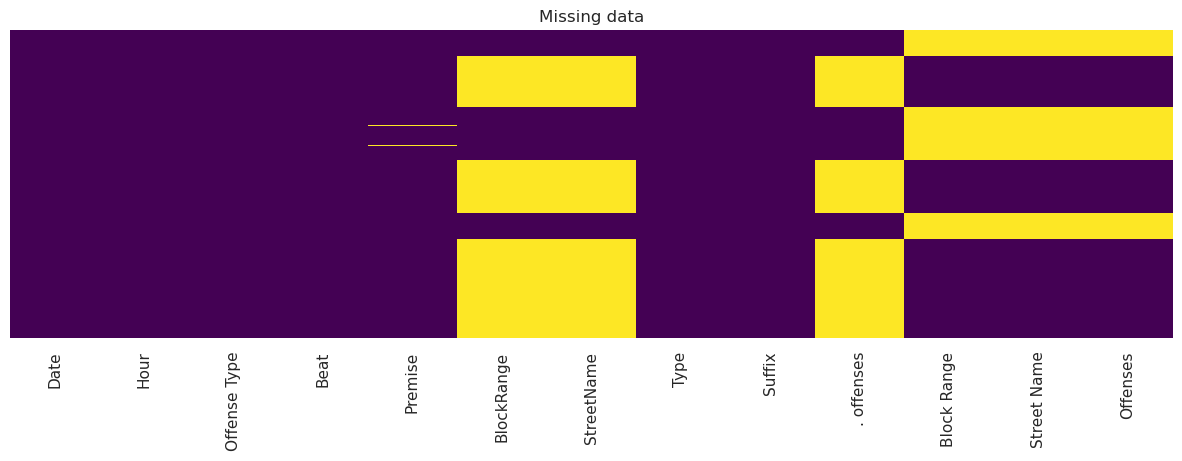

In [12]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## change columns

In [13]:
df['block_range'] = pd.concat([df['Block Range'].dropna(),
                              df['BlockRange'].dropna()]).reindex_like(df)

df['street_name'] = pd.concat([df['Street Name'].dropna(),
                              df['StreetName'].dropna()]).reindex_like(df)

df['offenses'] = pd.concat([df['. offenses'].dropna(),
                              df['Offenses'].dropna()]).reindex_like(df)


# drop unused columns

df = df.drop([  'Block Range',
 'BlockRange','Street Name','StreetName','. offenses','Offenses'], axis = 1)

In [14]:
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [15]:
df.apply(lambda x: sum(x.isnull()))

date              0
hour              0
offense_type      0
beat              0
premise         487
type              0
suffix            0
block_range       0
street_name       2
offenses          0
dtype: int64

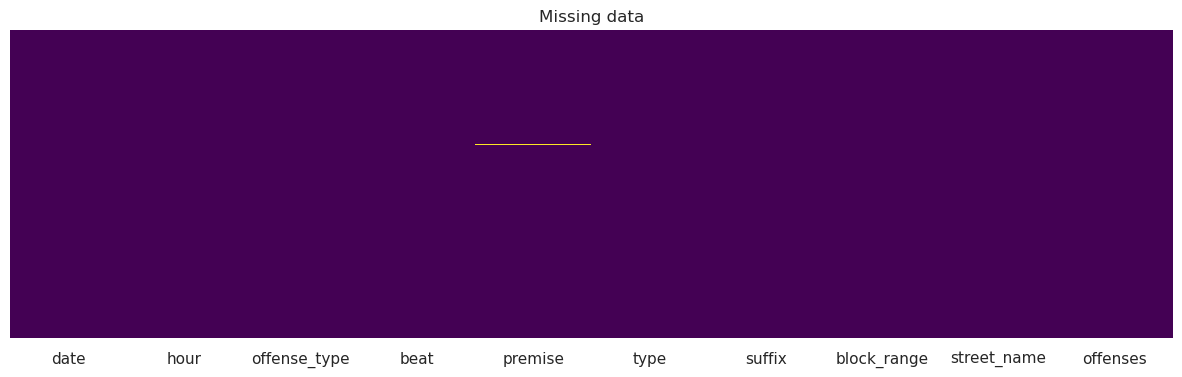

In [16]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Fix missing data

In [17]:
df[df.premise.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
30,2017-04-29 00:00:00,21,Burglary,10H10,NaN,BLVD,-,4700-4799,HARRISBURG,1.0
132,2017-04-16 00:00:00,7,Burglary,10H40,NaN,-,-,2700-2799,TRAVIS,1.0
185,2017-04-06 00:00:00,22,Theft,10H40,NaN,ST,-,1500-1599,HADLEY,1.0
259,2017-04-18 00:00:00,1,Theft,10H50,NaN,ST,-,3900-3999,DENNIS,1.0
391,2017-04-04 00:00:00,22,Aggravated Assault,10H60,NaN,BLVD,-,2800-2899,SOUTHMORE,1.0
...,...,...,...,...,...,...,...,...,...,...
80864,2017-03-07 00:00:00,21,Robbery,9C20,NaN,ST,-,6400-6499,MARKET,1.0
80893,2017-03-15 00:00:00,0,Theft,9C30,NaN,FWY,-,10300-10399,EAST,1.0
80932,2017-03-23 00:00:00,10,Burglary,9C30,NaN,DR,-,400-499,MERCURY,1.0
80997,2017-03-08 00:00:00,20,Theft,9C40,NaN,FWY,-,12000-12099,EAST,1.0


In [18]:
## Change null values to UNK

df["premise"].fillna("UNK", inplace = True)

In [19]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
type            0
suffix          0
block_range     0
street_name     2
offenses        0
dtype: int64

In [20]:
df[df.street_name.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
87061,05/13/2017,9,Aggravated Assault,20G10,Restaurant or Cafeteria,-,-,10300-10399,NaN,1.0
90946,05/04/2017,22,Theft,8C10,Service or Gas Station,-,-,9400-9499,NaN,1.0


In [21]:
## Change null values to UNK

df["street_name"].fillna("UNK", inplace = True)

In [22]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
type            0
suffix          0
block_range     0
street_name     0
offenses        0
dtype: int64

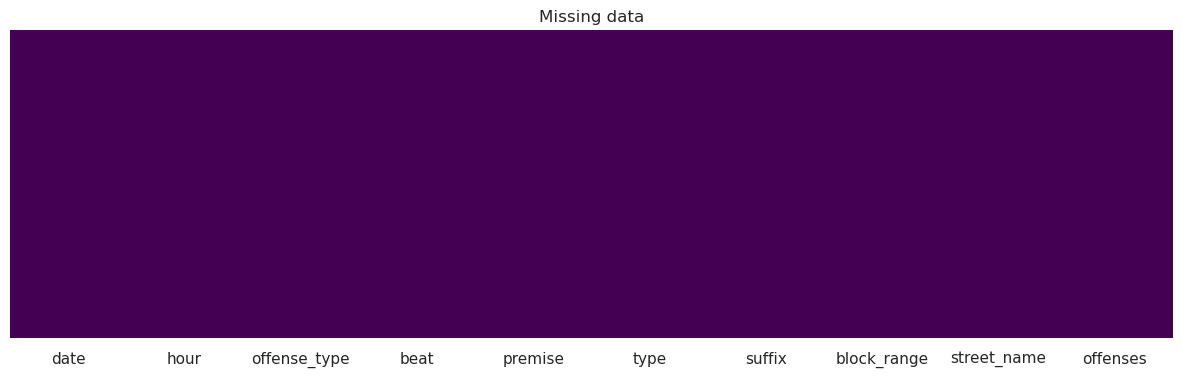

In [23]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [24]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119727 entries, 0 to 119726
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  119727 non-null  object        
 1   beat          119727 non-null  object        
 2   premise       119727 non-null  object        
 3   type          119727 non-null  object        
 4   suffix        119727 non-null  object        
 5   block_range   119727 non-null  object        
 6   street_name   119727 non-null  object        
 7   offenses      119727 non-null  float64       
 8   date_time     119727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 8.2+ MB


In [26]:
df.head()

,offense_type,beat,premise,type,suffix,block_range,street_name,offenses,date_time
0,Burglary,10H10,Residence or House,-,-,200-299,CLIFTON,1.0,2017-04-10 15:00:00
1,Theft,10H10,Restaurant or Cafeteria Parking Lot,ST,-,2300-2399,CANAL,1.0,2017-04-11 15:00:00
2,Theft,10H10,Restaurant or Cafeteria Parking Lot,ST,-,2300-2399,CANAL,1.0,2017-04-11 17:00:00
3,Burglary,10H10,Miscellaneous Business (Non-Specific),ST,-,4600-4699,CANAL,1.0,2017-04-12 09:00:00
4,Theft,10H10,"Other, Unknown, or Not Listed",LN,-,100-199,ADAM,1.0,2017-04-12 19:00:00


## Convert offenses to integer

In [27]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119727 entries, 0 to 119726
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  119727 non-null  object        
 1   beat          119727 non-null  object        
 2   premise       119727 non-null  object        
 3   type          119727 non-null  object        
 4   suffix        119727 non-null  object        
 5   block_range   119727 non-null  object        
 6   street_name   119727 non-null  object        
 7   offenses      119727 non-null  int64         
 8   date_time     119727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.2+ MB


# Create year column

In [29]:
df['year'] = 2017
df.head()

,offense_type,beat,premise,type,suffix,block_range,street_name,offenses,date_time,year
0,Burglary,10H10,Residence or House,-,-,200-299,CLIFTON,1,2017-04-10 15:00:00,2017
1,Theft,10H10,Restaurant or Cafeteria Parking Lot,ST,-,2300-2399,CANAL,1,2017-04-11 15:00:00,2017
2,Theft,10H10,Restaurant or Cafeteria Parking Lot,ST,-,2300-2399,CANAL,1,2017-04-11 17:00:00,2017
3,Burglary,10H10,Miscellaneous Business (Non-Specific),ST,-,4600-4699,CANAL,1,2017-04-12 09:00:00,2017
4,Theft,10H10,"Other, Unknown, or Not Listed",LN,-,100-199,ADAM,1,2017-04-12 19:00:00,2017


## change order of columns

In [30]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2017-04-10 15:00:00,1,Burglary,200-299,CLIFTON,-,-,10H10,Residence or House,2017
1,2017-04-11 15:00:00,1,Theft,2300-2399,CANAL,ST,-,10H10,Restaurant or Cafeteria Parking Lot,2017
2,2017-04-11 17:00:00,1,Theft,2300-2399,CANAL,ST,-,10H10,Restaurant or Cafeteria Parking Lot,2017
3,2017-04-12 09:00:00,1,Burglary,4600-4699,CANAL,ST,-,10H10,Miscellaneous Business (Non-Specific),2017
4,2017-04-12 19:00:00,1,Theft,100-199,ADAM,LN,-,10H10,"Other, Unknown, or Not Listed",2017


## Save to bucket

In [31]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2017.csv'

In [32]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 811 ms, sys: 72 ms, total: 883 ms
Wall time: 16.9 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2017.csv'],
 'partitions_values': {}}

# Save Sample

In [33]:
%%time
sample_100 = df.sample(100)


bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 24.2 ms, sys: 29 µs, total: 24.2 ms
Wall time: 320 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2017.csv'],
 'partitions_values': {}}